In [1]:
!pip install tensorflow-gpu==2.7.0 opencv-python tensorflow_datasets matplotlib pycocotools;

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [20]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import tensorflow_datasets as tfds
import datetime
from coco import COCO
from coco_final_labels import labels as coco_labels
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib as plt
from tensorflow import keras
import random

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

2022-08-03 12:09:17.384036: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 12:09:17.391884: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 12:09:17.392117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [21]:
LAST_DENSE = 1024
SOFTMAX_OUT = True
FROM_LOGITS = False
LEARNING_RATE = 0.0001
INFO = "-"
TRAIN_IMAGES = 'data/coco_onehot_train'
VAL_IMAGES = 'data/coco_onehot_val'
TRANSFER_TRAIN_IMAGES ='data/transfer_train'
TRANSFER_VAL_IMAGES = 'data/transfer_val'
BATCH_SIZE = 16

CONFIG_STRING = "batch_size: {0} | last_dense: {1} | softmax: {2} | from_logits: {3} | lr: {4} | info: {5}"

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [22]:
train_files = {}
for d in os.listdir(TRAIN_IMAGES):
    files = os.listdir(f"{TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        train_files[d] = files

print(len(train_files))

val_files = {}
for d in os.listdir(VAL_IMAGES):
    files = os.listdir(f"{VAL_IMAGES}/{d}")
    if len(files) > 0:
        val_files[d] = files

print(len(val_files))

transfer_train_files = {}
for d in os.listdir(TRANSFER_TRAIN_IMAGES):
    files = os.listdir(f"{TRANSFER_TRAIN_IMAGES}/{d}")
    if len(files) > 0:
        transfer_train_files[d] = files

print(len(transfer_train_files))

transfer_val_files = {}
for d in os.listdir(TRANSFER_VAL_IMAGES):
    files = os.listdir(f"{TRANSFER_VAL_IMAGES}/{d}")
    if len(files) > 0:
        transfer_val_files[d] = files

print(len(transfer_val_files))

80
80
6
6


In [23]:
def load_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224,224))
    image = image/255.0
    return image

def preprocess_triplets(anchor, positive, negative):
    return (load_image(anchor), load_image(positive), load_image(negative))

In [24]:
def get_training_data(labels, epoch_size=1024, training: bool=True, transfer: bool=False):
    X_a = []
    X_p = []
    X_n = []

    available_classes = labels

    if training:
        for i in range(epoch_size):
            c = random.choice(available_classes)
            n = random.choice([d for d in available_classes if d is not c])
            anchor = random.choice(train_files[c])
            positive = random.choice(train_files[c])
            negative = random.choice(train_files[n])

            X_a.append(f"{TRAIN_IMAGES}/{c}/{anchor}")
            X_p.append(f"{TRAIN_IMAGES}/{c}/{positive}")
            X_n.append(f"{TRAIN_IMAGES}/{n}/{negative}")

    if transfer:
        for i in range(int(epoch_size/2/80)):
            c = random.choice(available_classes)
            n = random.choice([d for d in available_classes if d is not c])
            anchor = random.choice(transfer_train_files[c])
            positive = random.choice(transfer_train_files[c])
            negative = random.choice(transfer_train_files[n])

            X_a.append(f"{TRANSFER_TRAIN_IMAGES}/{c}/{anchor}")
            X_p.append(f"{TRANSFER_TRAIN_IMAGES}/{c}/{positive}")
            X_n.append(f"{TRANSFER_TRAIN_IMAGES}/{n}/{negative}")

    return (X_a, X_p, X_n)

def get_training_dataset(labels, epoch_size=1024, training: bool=True, transfer: bool=False):
    data = get_training_data(labels, epoch_size, training, transfer)
    a = tf.data.Dataset.from_tensor_slices(data[0])
    b = tf.data.Dataset.from_tensor_slices(data[1])
    y = tf.data.Dataset.from_tensor_slices(data[2])
    final_data = tf.data.Dataset.zip((a,b,y))
    processed_data = final_data.map(preprocess_triplets)
    return processed_data

def get_validation_dataset(labels, training: bool=True, transfer: bool=False):
    X_a = []
    X_p = []
    X_n = []

    if training:
        for c in labels:
            for file in val_files[c]:
                anchor = file
                positive = random.choice(val_files[c])
                negative_class = random.choice([d for d in labels if d is not c])
                negative = random.choice(val_files[negative_class])
                X_a.append(f"{VAL_IMAGES}/{c}/{anchor}")
                X_p.append(f"{VAL_IMAGES}/{c}/{positive}")
                X_n.append(f"{VAL_IMAGES}/{negative_class}/{negative}")

    if transfer:
        for c in labels:
            for file in transfer_val_files[c]:
                anchor = file
                positive = random.choice(transfer_val_files[c])
                negative_class = random.choice([d for d in labels if d is not c])
                negative = random.choice(transfer_val_files[negative_class])
                X_a.append(f"{TRANSFER_VAL_IMAGES}/{c}/{anchor}")
                X_p.append(f"{TRANSFER_VAL_IMAGES}/{c}/{positive}")
                X_n.append(f"{TRANSFER_VAL_IMAGES}/{negative_class}/{negative}")

    a = tf.data.Dataset.from_tensor_slices(X_a)
    b = tf.data.Dataset.from_tensor_slices(X_p)
    y = tf.data.Dataset.from_tensor_slices(X_n)
    final_data = tf.data.Dataset.zip((a,b,y))
    processed_data = final_data.map(preprocess_triplets)
    return processed_data

In [25]:
train_data = get_training_dataset(coco_labels, 1024, True)
train_data = train_data.shuffle(BATCH_SIZE*10)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(BATCH_SIZE)

(16, 224, 224, 3)


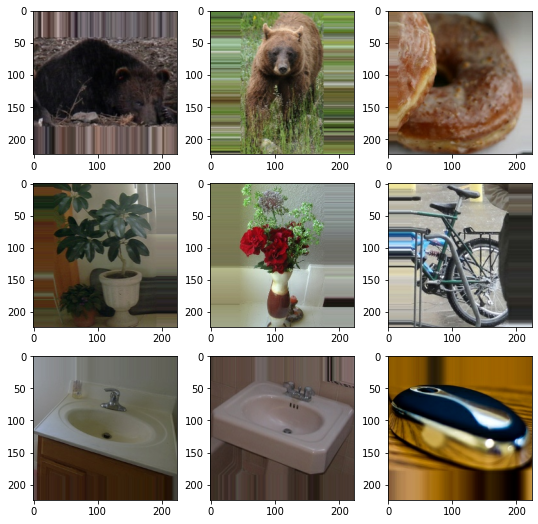

In [32]:
img_batch = next(iter(train_data))

fig = plt.pyplot.figure(figsize=(9,9))
axs = fig.subplots(3,3)

print(img_batch[2].shape)

for i in range(3):
    axs[0, i].imshow(img_batch[i][0])
    axs[1, i].imshow(img_batch[i][1])
    axs[2, i].imshow(img_batch[i][2])

In [33]:
resnet50 = keras.applications.ResNet50V2(include_top=False, weights="imagenet", input_shape=(224,224,3))
resnet50.summary()
resnet50.trainable = True

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [35]:
flatten = GlobalAveragePooling2D()(resnet50.output)
dense1 = Dense(1024, activation="relu")(flatten)
dense1 = BatchNormalization()(dense1)
dense2 = Dense(512, activation="relu")(dense1)
dense2 = BatchNormalization()(dense2)
output = Dense(256, activation="sigmoid")(dense2)

embedding = Model(resnet50.input, output, name="Embedding")

In [36]:
class DistanceLayer(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

anchor_input = Input(name="anchor", shape=(224,224,3))
positive_input = Input(name="positive", shape=(224,224,3))
negative_input = Input(name="negative", shape=(224,224,3))

distances = DistanceLayer()(
    embedding(tf.keras.applications.resnet.preprocess_input(anchor_input)),
    embedding(tf.keras.applications.resnet.preprocess_input(positive_input)),
    embedding(tf.keras.applications.resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [37]:
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.cosine_similarity = tf.keras.metrics.CosineSimilarity()

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        
        grads = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(grads, self.siamese_network.trainable_weights)
        )
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        loss = self._compute_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    
    @property
    def metrics(self):
        return [self.loss_tracker]

In [38]:
siamese_model = SiameseModel(siamese_network, margin=0.1)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001))

Epoch 1/20
 779/1024 [=====================>........] - ETA: 1:26 - loss: 0.1000

KeyboardInterrupt: 

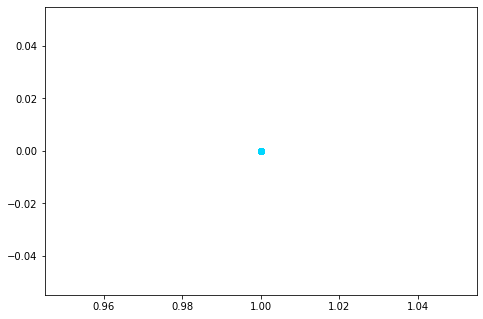

In [78]:
val_data = get_validation_dataset(coco_labels, True)
val_data = val_data.shuffle(BATCH_SIZE*10)
val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.prefetch(BATCH_SIZE)
train_data = get_training_dataset(coco_labels, 2**18, True)
train_data = train_data.shuffle(BATCH_SIZE*10)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(BATCH_SIZE)

siamese_model.fit(train_data, batch_size=BATCH_SIZE, steps_per_epoch=2**10, epochs=20, validation_data=val_data)
# for epoch in range(100):
#     print(epoch)
#     siamese_model.fit(train_data, )
#     if epoch % 10 == 0:
#         eval_loss = siamese_model.evaluate(val_data)
#         print(eval_loss)

In [77]:
import keras.backend as K
def euclidean_dist(x,y):
    return K.sqrt(K.sum(K.square(x - y), axis=-1))

cosine_similarity = tf.keras.metrics.CosineSimilarity()
img_batch = next(iter(val_data))

anchor_embed = embedding(np.array(img_batch[0][0]).reshape(-1,224,224,3))
pos_embed = embedding(np.array(img_batch[0][1]).reshape(-1,224,224,3))
neg_embed = embedding(np.array(img_batch[0][2]).reshape(-1,224,224,3))

positive_similarity = euclidean_dist(anchor_embed, pos_embed)
print(positive_similarity)
negative_embed = euclidean_dist(anchor_embed, neg_embed)
print(negative_embed)

tf.Tensor([1.4141922], shape=(1,), dtype=float32)
tf.Tensor([1.4142095], shape=(1,), dtype=float32)


In [67]:
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
11598/11598 [==============================] - ETA: 0s - loss: 0.3278